In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import re
import math
pd.options.mode.chained_assignment = None

In [120]:
af= pd.read_excel('Airfare.xlsx', header=0)
af.drop(columns='tbl',inplace=True)
af.head(2)

,Year,quarter,mkt_fare,citymarketid_1,citymarketid_2,city1,city2,carairlineid,car,carpax,carpaxshare,caravgfare,fareinc_min,fareinc_minpaxsh,fareinc_max,fare_inc_maxpaxsh,fare_inc_x3paxsh,Geocoded_City1,Geocoded_City2,tbl5pk
0,2006,3,87.41,34057,31884,"Portland, OR","Spokane, WA",19393,WN,34330,0.59,80.44,75,0.44,125,0.25,0.00,"Portland, OR\n(45.516018, -122.681425)","Spokane, WA\n(47.658999, -117.425022)",20063340573188419393WN
1,1997,4,224.47,30721,30198,"Boston, MA (Metropolitan Area)","Pittsburgh, PA",20355,US,68280,0.92,226.21,75,0.07,400,0.25,0.42,"Boston, MA (Metropolitan Area)\n(42.358894, -7...","Pittsburgh, PA\n(40.442169, -79.994945)",19974307213019820355US


## Data filtering

In [121]:
af1 = af[af['car'].isin(['AA', 'UA'])]
af1.shape

(3329, 20)

In [122]:
af1 = af1[(af1['Year'] >= 2000) & (af1['Year'] <= 2002)]

In [123]:
af1[['dep_city', 'dep_state']] = af1['city1'].str.split(', ', expand=True)
af1[['arr_city', 'arr_state']] = af1['city2'].str.split(', ', expand=True)
af1.drop(columns=['city1','city2'], inplace=True, axis=1)
af1['dep_state'] = af1['dep_state'].replace('NY (Metropolitan Area)', 'NY')
af1['arr_state']= af1['arr_state'].replace('NY (Metropolitan Area)', 'NY')

In [124]:
def extract_coordinates(text):
    matches = re.findall(r'\(([^)]+)\)', text)
    return matches[-1] if matches else None  # Get the last match in case of multiple occurrences

# Use .loc to assign the new column values safely
af1.loc[:, 'geo1_coordinates'] = af1['Geocoded_City1'].apply(extract_coordinates)
af1.loc[:, 'geo2_coordinates'] = af1['Geocoded_City2'].apply(extract_coordinates)

# To check the results
print(af1[['geo1_coordinates', 'geo2_coordinates']])

             geo1_coordinates        geo2_coordinates
22     39.738453, -104.984853  61.096484, -160.967455
102    39.738453, -104.984853   35.468494, -97.521264
161     43.597772, -83.884521  39.738453, -104.984853
162     41.775002, -87.696388   40.442169, -79.994945
184      40.11086, -77.035636   36.166687, -86.779932
...                       ...                     ...
11653    40.11086, -77.035636   35.143378, -90.052136
11717   41.775002, -87.696388   35.143378, -90.052136
11766  39.738453, -104.984853  35.167852, -103.726151
11807   38.256078, -85.751569   38.630276, -90.200309
11849   41.775002, -87.696388   35.143378, -90.052136

[310 rows x 2 columns]


In [125]:
def convert_to_tuple(coord_str):
    if coord_str:  # Ensure the string is not None or empty
        lat, lon = coord_str.split(', ')
        return float(lat), float(lon)
    return None

# Use apply() with a lambda function to update the DataFrame more idiomatically
af1['data_updated'] = af1.apply(
    lambda row: (
        convert_to_tuple(row['geo1_coordinates']), 
        convert_to_tuple(row['geo2_coordinates'])
    ), 
    axis=1
)

# Check the results
print(af1['data_updated'])

22       ((39.738453, -104.984853), (61.096484, -160.96...
102      ((39.738453, -104.984853), (35.468494, -97.521...
161      ((43.597772, -83.884521), (39.738453, -104.984...
162      ((41.775002, -87.696388), (40.442169, -79.9949...
184      ((40.11086, -77.035636), (36.166687, -86.779932))
                               ...                        
11653    ((40.11086, -77.035636), (35.143378, -90.052136))
11717    ((41.775002, -87.696388), (35.143378, -90.0521...
11766    ((39.738453, -104.984853), (35.167852, -103.72...
11807    ((38.256078, -85.751569), (38.630276, -90.2003...
11849    ((41.775002, -87.696388), (35.143378, -90.0521...
Name: data_updated, Length: 310, dtype: object


In [126]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Difference in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Earth's radius in miles
    R = 3959
    distance = R * c
    return distance


# Calculate distances with corrected coordinates
af1['distance_in_miles'] = [haversine(lat1, lon1, lat2, lon2) for (lat1, lon1), (lat2, lon2) in af1['data_updated']]

In [127]:
af1= af1.drop(columns=['citymarketid_1',
       'citymarketid_2','carairlineid',
       'carpaxshare', 'caravgfare', 'fareinc_min', 'fareinc_minpaxsh',
       'fareinc_max', 'fare_inc_maxpaxsh', 'fare_inc_x3paxsh',
       'Geocoded_City1', 'Geocoded_City2', 'tbl5pk','dep_city', 'arr_city', 'geo1_coordinates','geo2_coordinates','data_updated'])

## Creating Variables: RPM,Status, NY_Based, FROM_NY, TO_NY 

In [130]:
af1['rpm'] = af1['distance_in_miles'] * af1['carpax']

In [131]:
af1['NY_Based']= af1.apply(lambda row: 1 if row['dep_state'] == 'NY' or row['arr_state'] == 'NY' else 0, axis=1)
af1['FROM_NY']= af1.apply(lambda row: 1 if row['dep_state'] == 'NY' else 0, axis=1)
af1['TO_NY']= af1.apply(lambda row: 1 if row['arr_state'] == 'NY' else 0, axis=1)

In [132]:
def determine_status(row):
    if row['Year'] < 2001:
        return 0
    if row['Year'] == 2001:
        if row['quarter']<3:
            return 0
        if row['quarter']>=3:
            return 1
    else:
        return 1  

# Apply the function to each row
af1['Status'] = af1.apply(determine_status, axis=1)

## Data Visualization 

In [133]:
#From NY Dataset
af2= af1[af1['FROM_NY']==1]
# To NY Dataset
af3= af1[af1['TO_NY']==1]
# Not NY
af4= af1[af1['NY_Based']==0]
# NY Based: From and To NY
af5= af1[af1['NY_Based']==1]

In [160]:
af2_1 = pd.DataFrame(af2.groupby(['Year']).agg({
    'mkt_fare': 'mean',
    'carpax': 'mean',
    'rpm':'mean'
})).reset_index()

af3_1 = pd.DataFrame(af3.groupby(['Year']).agg({
    'mkt_fare': 'mean',
    'carpax': 'mean',
    'rpm':'mean'
})).reset_index()

af4_1 = pd.DataFrame(af4.groupby(['Year']).agg({
    'mkt_fare': 'mean',
    'carpax': 'mean',
    'rpm':'mean'
})).reset_index()

af5_1 = pd.DataFrame(af5.groupby(['Year']).agg({
    'mkt_fare': 'mean',
    'carpax': 'mean',
    'rpm':'mean'
})).reset_index()

## Market Fare: From_NY Vs Non NY Flights 

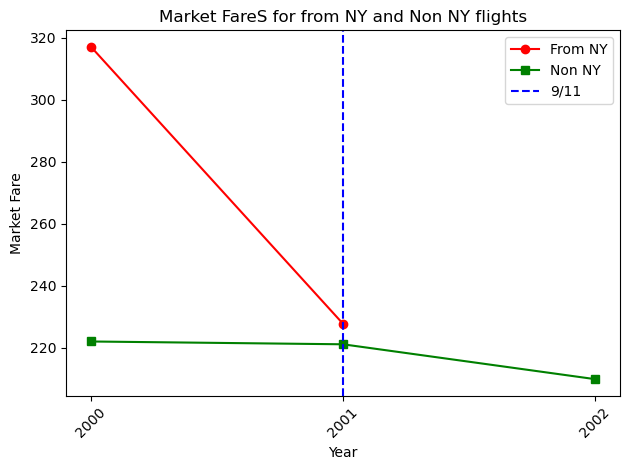

In [161]:
plt.plot(af2_1['Year'].astype('str'), af2_1['mkt_fare'], marker='o', color='red', label='From NY')
plt.plot(af4_1['Year'].astype('str'), af4_1['mkt_fare'], marker='s', color='green', label='Non NY')
plt.xlabel('Year')
plt.ylabel('Market Fare')
plt.title('Market FareS for from NY and Non NY flights')
plt.axvline(x= '2001', color='blue', linestyle='--', label='9/11')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ticklabel_format(axis='y', style='plain')
plt.legend()
plt.show()

## Market Fare: To_NY Vs Non NY Flights 

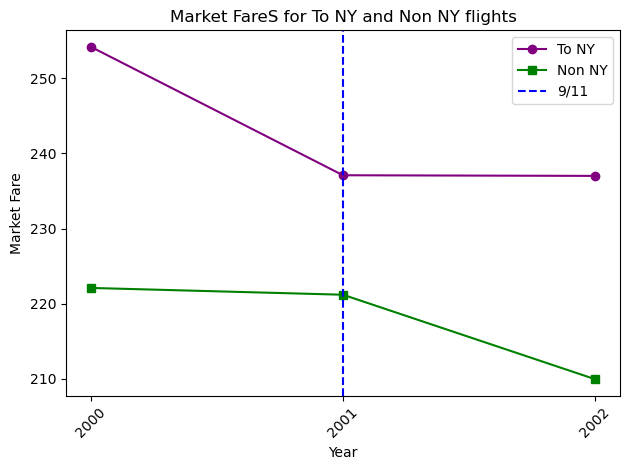

In [162]:
plt.plot(af3_1['Year'].astype('str'), af3_1['mkt_fare'], marker='o', color='purple', label='To NY')
plt.plot(af4_1['Year'].astype('str'), af4_1['mkt_fare'], marker='s', color='green', label='Non NY')
plt.xlabel('Year')
plt.ylabel('Market Fare')
plt.title('Market FareS for To NY and Non NY flights')
plt.axvline(x= '2001', color='blue', linestyle='--', label='9/11')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ticklabel_format(axis='y', style='plain')
plt.legend()
plt.show()

## Market Fare: NY Based Vs Non NY Based Flights 

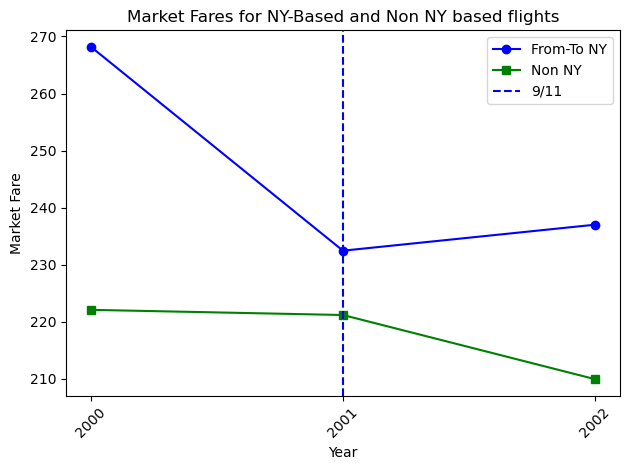

In [163]:
plt.plot(af5_1['Year'].astype('str'), af5_1['mkt_fare'], marker='o', color='blue', label='From-To NY')
plt.plot(af4_1['Year'].astype('str'), af4_1['mkt_fare'], marker='s', color='green', label='Non NY')
plt.xlabel('Year')
plt.ylabel('Market Fare')
plt.title('Market Fares for NY-Based and Non NY based flights')
plt.axvline(x= '2001', color='blue', linestyle='--', label='9/11')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ticklabel_format(axis='y', style='plain')
plt.legend()
plt.show()

## Passenger Volume:From NY Vs Non NY Based Flights 

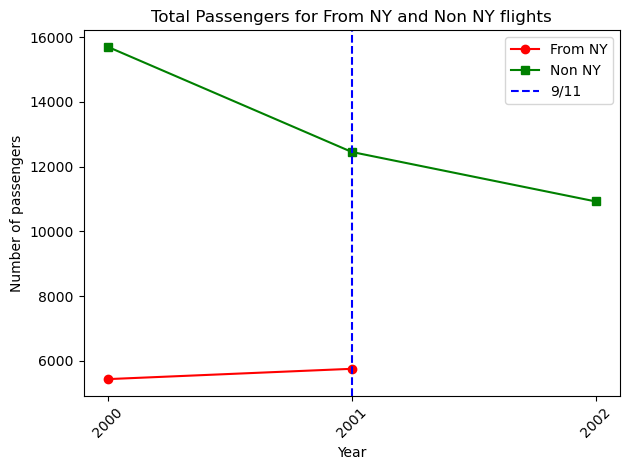

In [164]:
plt.plot(af2_1['Year'].astype('str'), af2_1['carpax'], marker='o', color='red', label='From NY')
plt.plot(af4_1['Year'].astype('str'), af4_1['carpax'], marker='s', color='green', label='Non NY')
plt.xlabel('Year')
plt.ylabel('Number of passengers')
plt.title('Total Passengers for From NY and Non NY flights')
plt.axvline(x= '2001', color='blue', linestyle='--', label='9/11')
plt.xticks(rotation=45)
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
plt.legend()
plt.show()

## Passenger Volume: To NY Vs Non NY Based Flights 

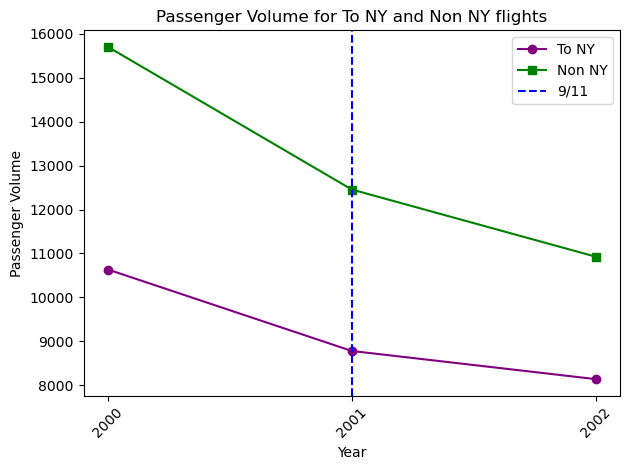

In [165]:
plt.plot(af3_1['Year'].astype('str'), af3_1['carpax'], marker='o', color='purple', label='To NY')
plt.plot(af4_1['Year'].astype('str'), af4_1['carpax'], marker='s', color='green', label='Non NY')
plt.xlabel('Year')
plt.ylabel('Passenger Volume')
plt.title('Passenger Volume for To NY and Non NY flights')
plt.axvline(x= '2001', color='blue', linestyle='--', label='9/11')
plt.xticks(rotation=45)
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
plt.legend()
plt.show()

## Passenger Volume: NY Based Vs Non NY Based Flights 

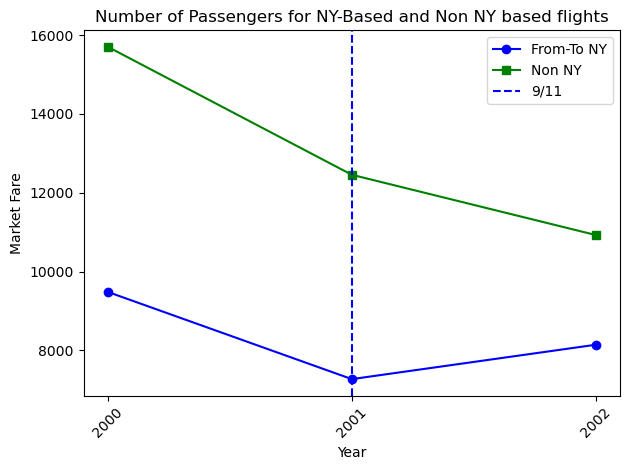

In [166]:
plt.plot(af5_1['Year'].astype('str'), af5_1['carpax'], marker='o', color='blue', label='From-To NY')
plt.plot(af4_1['Year'].astype('str'), af4_1['carpax'], marker='s', color='green', label='Non NY')
plt.xlabel('Year')
plt.ylabel('Market Fare')
plt.title('Number of Passengers for NY-Based and Non NY based flights')
plt.axvline(x= '2001', color='blue', linestyle='--', label='9/11')
plt.xticks(rotation=45)
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
plt.legend()
plt.show()

##  RPM: From NY Vs Non NY Based Flights

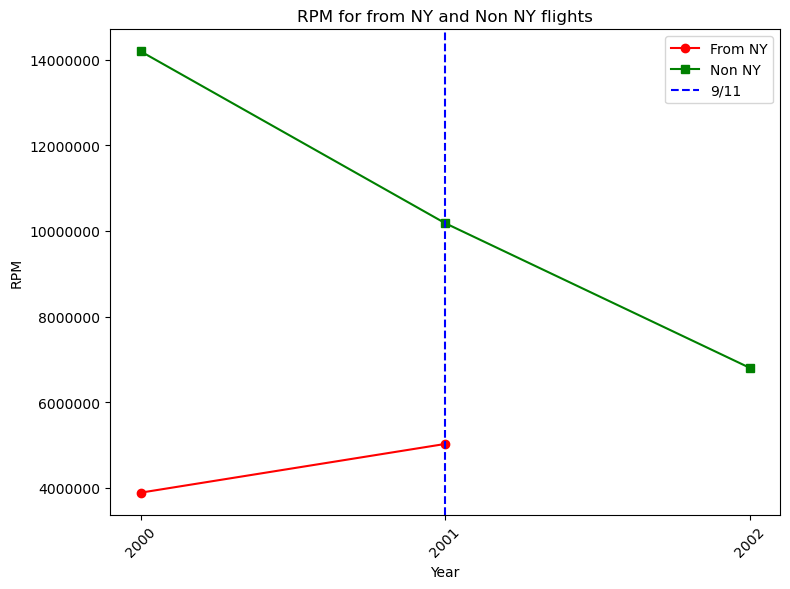

In [167]:
plt.figure(figsize=(8, 6)) 
plt.plot(af2_1['Year'].astype('str'), af2_1['rpm'], marker='o', color='red', label='From NY')
plt.plot(af4_1['Year'].astype('str'), af4_1['rpm'], marker='s', color='green', label='Non NY')
plt.xlabel('Year')
plt.ylabel('RPM')
plt.title('RPM for from NY and Non NY flights')
plt.axvline(x= '2001', color='blue', linestyle='--', label='9/11')
plt.xticks(rotation=45) 
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
plt.legend()
plt.show()

## RPM: To NY Vs Non NY Based Flights 

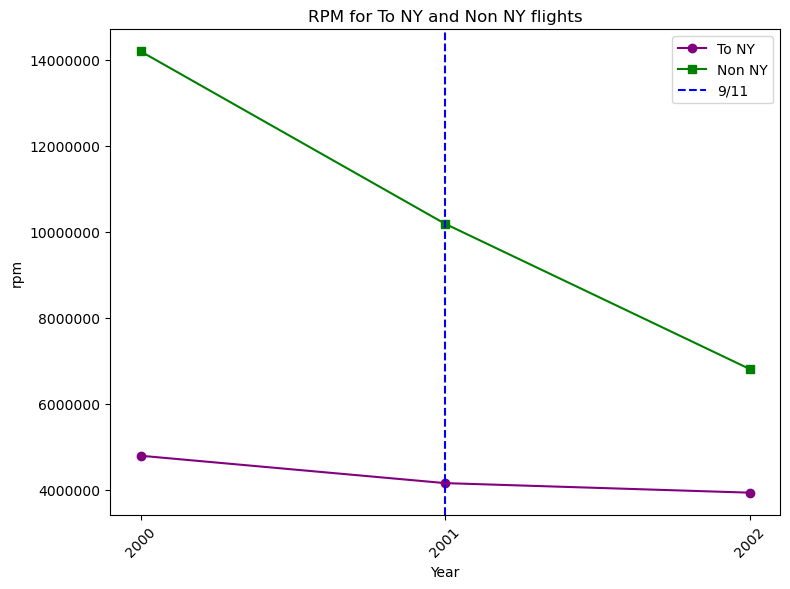

In [168]:
plt.figure(figsize=(8, 6)) 
plt.plot(af3_1['Year'].astype('str'), af3_1['rpm'], marker='o', color='purple', label='To NY')
plt.plot(af4_1['Year'].astype('str'), af4_1['rpm'], marker='s', color='green', label='Non NY')
plt.xlabel('Year')
plt.ylabel('rpm')
plt.title('RPM for To NY and Non NY flights')
plt.axvline(x= '2001', color='blue', linestyle='--', label='9/11')
plt.xticks(rotation=45) 
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
plt.legend()
plt.show()

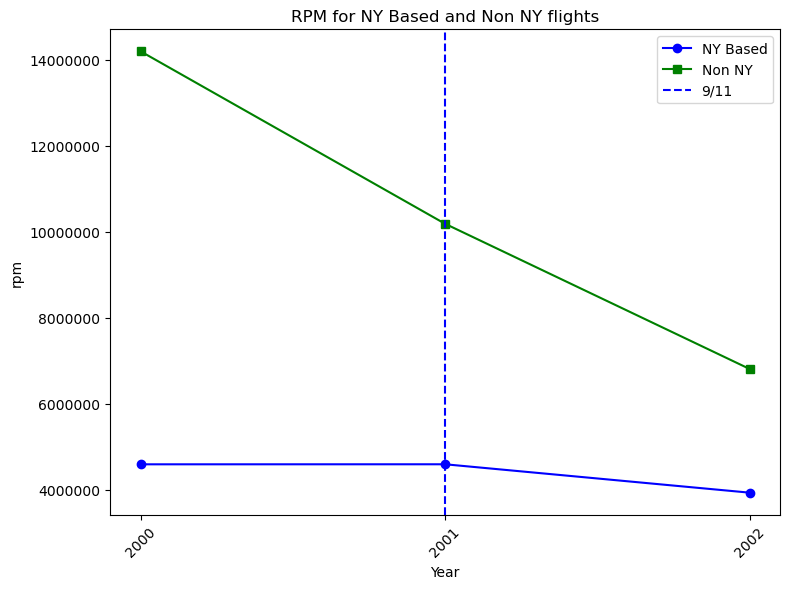

In [171]:
plt.figure(figsize=(8, 6)) 
plt.plot(af5_1['Year'].astype('str'), af5_1['rpm'], marker='o', color='blue', label='NY Based')
plt.plot(af4_1['Year'].astype('str'), af4_1['rpm'], marker='s', color='green', label='Non NY')
plt.xlabel('Year')
plt.ylabel('rpm')
plt.title('RPM for NY Based and Non NY flights')
plt.axvline(x= '2001', color='blue', linestyle='--', label='9/11')
plt.xticks(rotation=45) 
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
plt.legend()
plt.show()

## Regression Analysis 

In [174]:
a=af1

In [175]:
a= a.drop(columns=['Year','quarter','car','dep_state','arr_state','distance_in_miles'], axis=1)
a.head()

,mkt_fare,carpax,rpm,NY_Based,FROM_NY,TO_NY,Status
22,255.54,10950,3.016096e+07,0,0,0,1
102,250.75,2520,1.269248e+06,0,0,0,0
161,278.89,8790,9.826861e+06,0,0,0,0
162,219.07,6250,2.570260e+06,0,0,0,0
184,231.66,25610,1.524048e+07,0,0,0,0


## Developing an interaction term

In [176]:
a['Interaction']=a['NY_Based']*a['Status']

In [177]:
stat = pd.get_dummies(a['Status'], prefix='Status', drop_first=True)
tny = pd.get_dummies(a['TO_NY'], prefix='TO_NY', drop_first=True)
fny = pd.get_dummies(a['FROM_NY'], prefix='FROM_NY', drop_first=True)
nyb = pd.get_dummies(a['NY_Based'], prefix='NY_Based', drop_first=True)
inter = pd.get_dummies(a['Interaction'], prefix='Interaction', drop_first=True)
# Concatenate the dummy variables with the original DataFrame
a= pd.concat([a,stat, tny, fny,nyb, inter], axis=1)

## Assigning Dummy variables 

In [178]:
a=a.drop(columns=['NY_Based','FROM_NY','TO_NY','Status','Interaction'])
a['TO_NY_1']=a['TO_NY_1'].astype('int')
a['FROM_NY_1']=a['FROM_NY_1'].astype('int')
a['NY_Based_1']=a['NY_Based_1'].astype('int')
a['Status_1']=a['Status_1'].astype('int')
a['Interaction_1']=a['Interaction_1'].astype('int')

In [179]:
a.head()

,mkt_fare,carpax,rpm,Status_1,TO_NY_1,FROM_NY_1,NY_Based_1,Interaction_1
22,255.54,10950,3.016096e+07,1,0,0,0,0
102,250.75,2520,1.269248e+06,0,0,0,0,0
161,278.89,8790,9.826861e+06,0,0,0,0,0
162,219.07,6250,2.570260e+06,0,0,0,0,0
184,231.66,25610,1.524048e+07,0,0,0,0,0


## Outcome: Passenger Volume; Independent Variables: Status, NY Based, Interaction

In [182]:
# Selecting the independent variables (dummies) and the dependent variable
X1 = a.drop(columns=['carpax','TO_NY_1','FROM_NY_1','mkt_fare', 'rpm'])
y1 = a['carpax']  # Assuming 'mkt_fare' is the dependent variable

# Add a constant to the independent variables
X1 = sm.add_constant(X1)

# Fit the linear regression model
model1 = sm.OLS(y1, X1).fit()

# Print the summary of the model to see the results
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 carpax   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     6.532
Date:                Sun, 05 May 2024   Prob (F-statistic):           0.000270
Time:                        14:51:30   Log-Likelihood:                -3318.5
No. Observations:                 310   AIC:                             6645.
Df Residuals:                     306   BIC:                             6660.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.528e+04    827.573     18.462

## Outcome: Market Fare ; Independent Variables: Status, NY Based, Interaction 

In [183]:
# Selecting the independent variables (dummies) and the dependent variable
X2 = a.drop(columns=['carpax','TO_NY_1','FROM_NY_1','carpax', 'mkt_fare','rpm'])
y2 = a['mkt_fare']  # Assuming 'mkt_fare' is the dependent variable

# Add a constant to the independent variables
X2 = sm.add_constant(X2)

# Fit the linear regression model
model2 = sm.OLS(y2, X2).fit()

# Print the summary of the model to see the results
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:               mkt_fare   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.878
Date:                Sun, 05 May 2024   Prob (F-statistic):            0.00959
Time:                        14:51:43   Log-Likelihood:                -1736.4
No. Observations:                 310   AIC:                             3481.
Df Residuals:                     306   BIC:                             3496.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           227.3410      5.028     45.214

## Outcome: RPM; Independent Variables: Status, NY Based, Interaction 

In [180]:
# Selecting the independent variables (dummies) and the dependent variable
X3 = a.drop(columns=['carpax','TO_NY_1','FROM_NY_1','mkt_fare','rpm'])
y3 = a['rpm']  # Assuming 'mkt_fare' is the dependent variable

# Add a constant to the independent variables
X3 = sm.add_constant(X3)

# Fit the linear regression model
model3 = sm.OLS(y3, X3).fit()

# Print the summary of the model to see the results
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    rpm   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     8.651
Date:                Sun, 05 May 2024   Prob (F-statistic):           1.58e-05
Time:                        14:51:02   Log-Likelihood:                -5467.0
No. Observations:                 310   AIC:                         1.094e+04
Df Residuals:                     306   BIC:                         1.096e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.312e+07   8.47e+05     15.499